In [40]:
import numpy as np
def gen_data(mu, delta, n, d: int = 2):
    noise = np.random.normal(loc = 0, scale = 1, size=(n, d))
    mu = np.full((n, d), mu, dtype=np.float64)

    if delta == 0.0:
        return mu + noise, np.zeros(n)
    
    # 10% of the data are abnormal
    abnormal_idx = np.random.choice(n, int(n/10), replace=False)

    mu[abnormal_idx, :] += delta

    X = mu + noise 
    Y = np.zeros(n)
    Y[abnormal_idx] = 1
    return X, Y

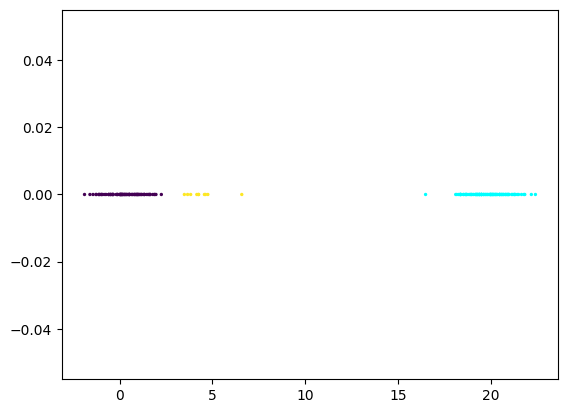

In [41]:
import matplotlib.pyplot as plt

"""Create synthetic dataset and dataloaders for domain adaptation."""
# Create datasets
ns, nt, d = 100, 100, 1
mu_s, mu_t = 0, 20
delta_s, delta_t = 4, 0
xs, ys = gen_data(mu_s, delta_s, ns, d)
xt, yt = gen_data(mu_t, delta_t, nt, d)

plt.scatter(xs[:, 0], np.zeros_like(xs[:, 0]), c=ys, cmap='viridis', s=2)
plt.scatter(xt[:, 0], np.zeros_like(xt[:, 0]), c=yt, cmap='cool', s=2)
plt.show()

In [42]:
def max_sum(X):
    return np.argmax(np.sum(X, axis=1))
x = np.vstack((xs, xt))
O = max_sum(x)
O
O = [O-100]

In [43]:
a = np.array([[1], [2], [3], [4], [5]])
b = np.sum(a, axis=1)
np.argmax(b)

4

In [44]:
print(x[O])
print(x[-1])

[[1.33048755]]
[18.83970761]


In [45]:
from mpmath import mp
mp.dps = 500

Oc = list(np.where(yt == 0)[0])
j = np.random.choice(O, 1, replace=False)[0]
etj = np.zeros((nt, 1))
etj[j][0] = 1
etOc = np.zeros((nt, 1))
etOc[Oc] = 1
etaj = np.vstack((np.zeros((ns, 1)), etj-(1/len(Oc))*etOc))
X = np.vstack((xs, xt))

etajTX = etaj.T.dot(X)
mu = np.vstack((np.full((ns,1), mu_s), np.full((nt,1), mu_t)))
sigma = np.identity(ns+nt)
etajTmu = etaj.T.dot(mu)
etajTsigmaetaj = etaj.T.dot(sigma).dot(etaj)
cdf = mp.ncdf((etajTX[0][0] - etajTmu[0][0]) / np.sqrt(etajTsigmaetaj[0][0]))
p_value = float(2 * min(cdf, 1 - cdf))
p_value

0.011065562885325559

In [46]:
def run_naive():
    ns, nt, d = 100, 100, 1
    mu_s, mu_t = 0, 20
    delta_s, delta_t = 4, 0
    xs, ys = gen_data(mu_s, delta_s, ns, d)
    xt, yt = gen_data(mu_t, delta_t, nt, d)

    X = np.vstack((xs, xt))
    O = max_sum(X)
    if O < 100:
        return None
    O = [O-100]
    Oc = list(np.where(yt == 0)[0])
    j = np.random.choice(O, 1, replace=False)[0]
    etj = np.zeros((nt, 1))
    etj[j][0] = 1
    etOc = np.zeros((nt, 1))
    etOc[Oc] = 1
    etaj = np.vstack((np.zeros((ns, 1)), etj-(1/len(Oc))*etOc))

    etajTX = etaj.T.dot(X)
    mu = np.vstack((np.full((ns,1), mu_s), np.full((nt,1), mu_t)))
    sigma = np.identity(ns+nt)
    etajTmu = etaj.T.dot(mu)
    etajTsigmaetaj = etaj.T.dot(sigma).dot(etaj)
    cdf = mp.ncdf((etajTX[0][0] - etajTmu[0][0]) / np.sqrt(etajTsigmaetaj[0][0]))
    p_value = float(2 * min(cdf, 1 - cdf))
    return p_value

FPR: 0.946


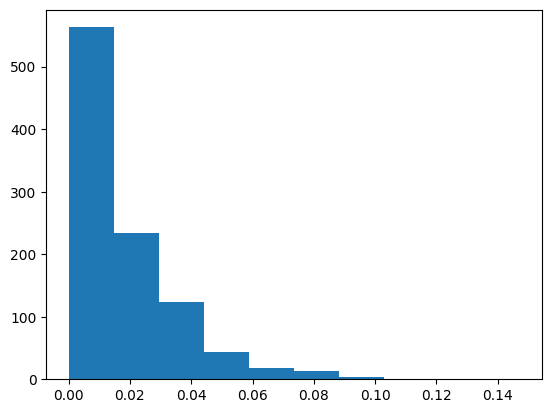

In [47]:
max_iteration = 1000
alpha = 0.05
list_p_value = []
count = 0

for i in range(max_iteration):
    p_value = run_naive()
    if p_value is None:
        continue
    list_p_value.append(p_value)
    if p_value <= alpha:
        count += 1
print(f'FPR: {count / max_iteration}')
plt.hist(list_p_value)
plt.show()

In [48]:
b = sigma.dot(etaj).dot(np.linalg.inv(etajTsigmaetaj))
a = (np.identity(ns+nt) - b.dot(etaj.T)).dot(X)

In [55]:
def intersect(itv1, itv2):
    # print(itv1, itv2)
    itv = [max(itv1[0], itv2[0]), min(itv1[1], itv2[1])]
    if itv[0] > itv[1]:
        return None    
    return itv

def solve_linear_inequality(u, v): #u + vz < 0
    if (v > -1e-16 and v < 1e-16):
        v = 0
        if (u < 0):
            return [-np.Inf, np.Inf]
        else:
            print('error')
            return None
    if (v < 0):
        return [-u/v, np.Inf]
    return [np.NINF, -u/v]

In [56]:
ao = a[O[0]+100][0]
bo = b[O[0]+100][0]
itv = [np.NINF, np.inf]
I = np.ones(X.shape[1])
for i in range(X.shape[0]):
    if (i != O[0]+100):
        ai = a[i][0]
        bi = b[i][0]
        sub_itv = solve_linear_inequality(ai-ao, bi-bo)
        itv = intersect(itv, sub_itv)
itv

[2.3093449687721703, inf]

In [58]:
def truncated_cdf(etajTy, mu, sigma, left, right):
    numerator = mp.ncdf((etajTy - mu) / sigma) - mp.ncdf((left - mu) / sigma)
    denominator = mp.ncdf((right - mu) / sigma) - mp.ncdf((left - mu) / sigma)
    if denominator <= 1e-16:
        true_cdf = 1
    else:
        true_cdf = numerator / denominator 
    return true_cdf
cdf = truncated_cdf(etajTX[0][0], etajTmu[0][0], np.sqrt(etajTsigmaetaj[0][0]), itv[0], itv[1])
p_value = float(2 * min(cdf, 1 - cdf))
p_value

0.9091506372338698

In [59]:
def run_basic_si():
    ns, nt, d = 100, 100, 1
    mu_s, mu_t = 0, 20
    delta_s, delta_t = 4, 0
    xs, ys = gen_data(mu_s, delta_s, ns, d)
    xt, yt = gen_data(mu_t, delta_t, nt, d)

    X = np.vstack((xs, xt))
    O = max_sum(X)
    if O < 100:
        return None
    O = [O-100]
    Oc = list(np.where(yt == 0)[0])
    j = np.random.choice(O, 1, replace=False)[0]
    etj = np.zeros((nt, 1))
    etj[j][0] = 1
    etOc = np.zeros((nt, 1))
    etOc[Oc] = 1
    etaj = np.vstack((np.zeros((ns, 1)), etj-(1/len(Oc))*etOc))

    etajTX = etaj.T.dot(X)
    mu = np.vstack((np.full((ns,1), mu_s), np.full((nt,1), mu_t)))
    sigma = np.identity(ns+nt)
    etajTmu = etaj.T.dot(mu)
    etajTsigmaetaj = etaj.T.dot(sigma).dot(etaj)

    b = sigma.dot(etaj).dot(np.linalg.inv(etajTsigmaetaj))
    a = (np.identity(ns+nt) - b.dot(etaj.T)).dot(X)

    ao = a[O[0]+100][0]
    bo = b[O[0]+100][0]
    itv = [np.NINF, np.inf]
    for i in range(X.shape[0]):
        if (i != O[0]+100):
            ai = a[i][0]
            bi = b[i][0]
            sub_itv = solve_linear_inequality(ai-ao, bi-bo)
            itv = intersect(itv, sub_itv)   
    cdf = truncated_cdf(etajTX[0][0], etajTmu[0][0], np.sqrt(etajTsigmaetaj[0][0]), itv[0], itv[1])
    p_value = float(2 * min(cdf, 1 - cdf))
    return p_value

FPR: 0.056


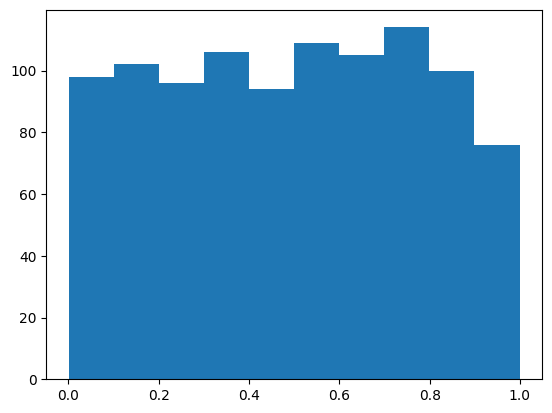

In [60]:
max_iteration = 1000
alpha = 0.05
list_p_value = []
count = 0

for i in range(max_iteration):
    p_value = run_basic_si()
    if p_value is None:
        continue
    list_p_value.append(p_value)
    if p_value <= alpha:
        count += 1
print(f'FPR: {count / max_iteration}')
plt.hist(list_p_value)
plt.show()